In [2]:
# ln -s ../code/analytic.py analytic.py
%matplotlib inline

import pandas
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as smtsa

import matplotlib.pyplot as pyplot

import thinkplot
import thinkstats2

In [5]:
transactions = pandas.read_csv('mj-clean.csv', parse_dates=[5])

In [6]:
transactions.describe()

,price,amount,ppg,lat,lon
count,147070.000000,147070.000000,147070.000000,146897.000000,146897.000000
mean,137.259516,15.336626,10.670560,37.858994,-91.988509
std,120.217590,11.145683,5.622977,5.008867,16.545298
min,4.000000,1.000000,1.020000,24.675731,-124.399110
25%,50.000000,5.000000,6.000000,33.990380,-104.804560
50%,100.000000,14.150000,10.600000,38.952526,-86.785248
75%,200.000000,28.300000,14.130000,41.598235,-79.107692
max,990.000000,28.300000,34.980000,49.054587,-67.086970


In [7]:
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [8]:
def GroupByQuality(transactions):
    groups = transactions.groupby('quality')
    dailies={}
    for name,group in groups:
        dailies[name] = GroupByDay(group)
    return dailies

def GroupByDay(transactions, func=np.mean):
    grouped = transactions[['date','ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year
    return daily

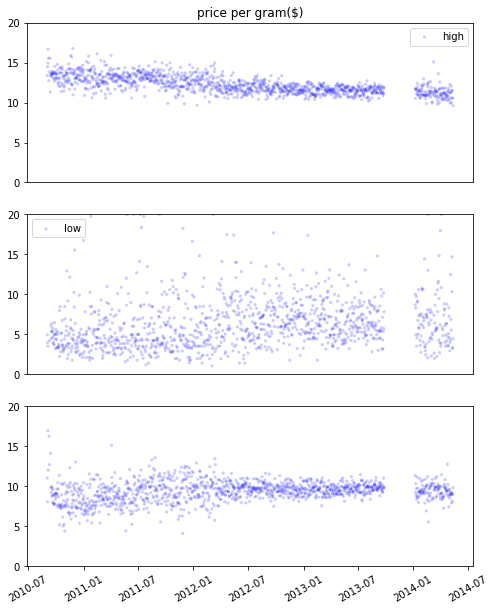

In [12]:
dailies = GroupByQuality(transactions)

thinkplot.PrePlot(rows=3)
for i, (name,daily) in enumerate(dailies.items()):
    thinkplot.SubPlot(i+1)
    title = 'price per gram($)' if i==0 else ''
    thinkplot.Config(ylim=[0,20], title=title)
    thinkplot.Scatter(daily.index, daily.ppg, s=10, label=name)
    if i==2:
        pyplot.xticks(rotation=30)
    else:
        thinkplot.Config(xticks=[])